## Project Title: RealWaste Classification using Convolution Neural Networks
### Student ID: 22052310
The main objective of project was to build 3 different sets of custom Convolutional Neural networks with different number of layers and research on how different type of hyperparameters affects the performance of models in term of real waste classification accuracy. The best custom model was compared with state of art pre-trained model MobileNetV3 and EfficientV2.


In [1]:
# Load python modules
# Modules from Tensorflow Keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Resizing, Rescaling
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

#Module from Seaborn, sklearn and Matplotlib.pyplot for data visualisation
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

#Module to shuffle the image and label data
from sklearn.utils import shuffle 

# datetime to record the training and prediction time
from datetime import datetime

# Perform iterature with progress bar
from tqdm import tqdm 

# numpy for mathematical operations
import numpy as np
#OpenCV for image processing
import cv2 as cv
#operating system
import os

In [2]:
# Define the class label
waste_class_names = ['Glass', 'Metal', 'Paper', 'Textile']
waste_class_label = {waste_class_name: i for i, waste_class_name in enumerate(waste_class_names)}
number_of_class = len(waste_class_names)
image_size = (64, 64)

In [3]:
# Check the waste label in integer
waste_class_label

{'Glass': 0, 'Metal': 1, 'Paper': 2, 'Textile': 3}

In [4]:
print('Number of classes:', number_of_class)

Number of classes: 4


In [5]:
resize_layer_32 = tf.keras.Sequential([
    Resizing(32, 32),
])

## Directory path to the Dataset 1 to 3

In [6]:
# Path to Datasets 1 to 3

# Dataset 1 with 4 classes - 270 images for training and 50 images for testing per class
train_ds_1 = 'C:/Mani/Dataset/dataset1/train_ds'
test_ds_1 = 'C:/Mani/Dataset/dataset1/test_ds'

# Dataset 2 with 4 classes - 450 images for training with data augmentation images and 50 images for testing
train_ds_2 = 'C:/Mani/Dataset/dataset2/train_ds'
test_ds_2 = 'C:/Mani/Dataset/dataset2/test_ds'

# Dataset 3 with 6 classes - 450 images for training with data augmentation images and 50 images for testing
train_ds_3 = 'C:/Mani/Dataset/dataset3/train_ds'
test_ds_3 = 'C:/Mani/Dataset/dataset3/test_ds'

## load_waste_data function to load datasets

In [7]:
#Custom function to load real waste image and label

def load_waste_data(train_path, test_path):
    """
    Create the dataset for training and testing
    
    Parameter
    arg1 : path to training waste image folder
    arg1 : path to testing waste image folder
        
    Return:
    test and training dataset with image and label
    
    """
    ds = [train_path, test_path]  
    
    result = []
    
    # Iterate through training and test sets
    for dataset in ds:
        
        #Create empty list for image and label
        waste_images = []
        waste_labels = []
        
        print("Loading waste image {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            waste_label = waste_class_label[folder]
            
            # Iterate through each image in the folder 
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                #Modified realwaste image with openCV 
                waste_image = cv.imread(img_path)
                # Change from BGR to RGB
                waste_image = cv.cvtColor(waste_image, cv.COLOR_BGR2RGB)
                # Alpha-contrast / beta-brightness
                #waste_image = cv.convertScaleAbs(waste_image, alpha=1.0, beta=1.1) 
                waste_image = cv.resize(waste_image, image_size) 
                
                # Append the realwaste image and its label
                waste_images.append(waste_image)
                waste_labels.append(waste_label)
                
        # change the realwaste image data type to float and label to ingeter.        
        waste_images = np.array(waste_images, dtype = 'float32')
        waste_labels = np.array(waste_labels, dtype = 'int32')   
        
        result.append((waste_images, waste_labels))

    return result

In [8]:
#Prepare dataset for training and testing
(train_images, train_labels), (test_images, test_labels) = load_waste_data(train_ds_2, test_ds_2)

Loading waste image C:/Mani/Dataset/dataset2/train_ds


100%|████████████████████████████████████████████████████████████████████████████████| 450/450 [00:05<00:00, 77.64it/s]


Loading waste image C:/Mani/Dataset/dataset2/test_ds


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 60.34it/s]


In [9]:
#Check the training dataset shape
train_images.shape, test_images.shape

((1800, 64, 64, 3), (200, 64, 64, 3))

In [10]:
# Shuffle both the training and test datasets
np.random.seed(321)
train_images, train_labels = shuffle(train_images, train_labels)
test_images, test_labels = shuffle(test_images, test_labels)

In [11]:
#Check the number of training dataset
print('No of training images:', train_images.shape[0])

No of training images: 1800


In [12]:
#Normalise training and testing images from 0,255 to 0,1
train_images = train_images / 255.0 
test_images = test_images / 255.0

## Display 25 real waste images from 6 classes

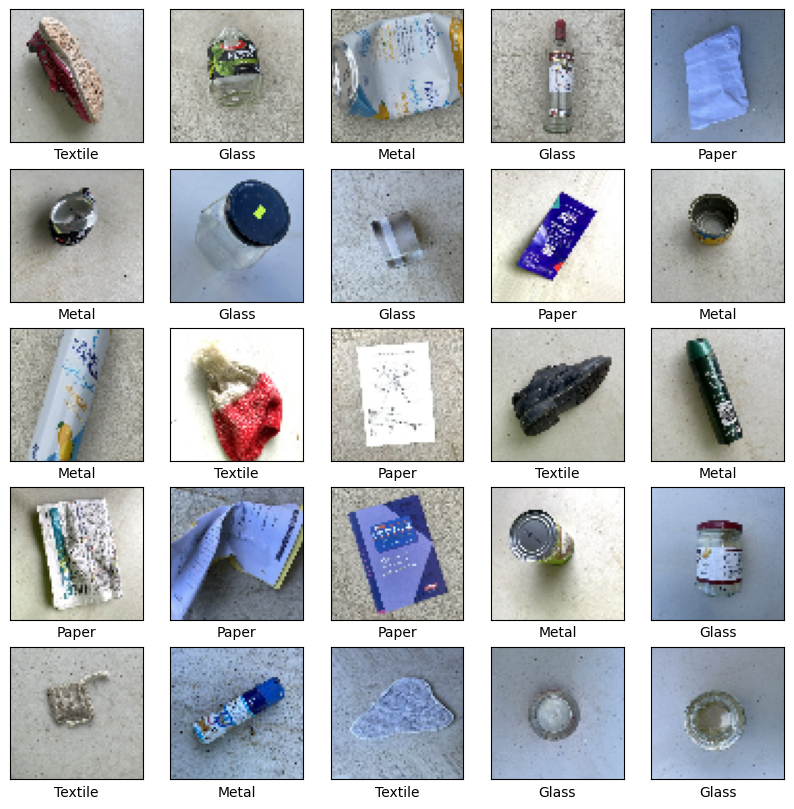

In [13]:
#Display 25 images 
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(waste_class_names[train_labels[i]])
plt.show()

## CNN custom Model 1 with 2 Convolution layers

In [14]:
#Sequential Model 1 with 2 Convolutional layers
# Model was built based on tf.keras.layers - with different type of layers as shown below:
#Conv2D, BatchNormalization, Maxpooling, Dropout, Dense, Flatten, resizing

model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input((64,64,3)),
    #resize_layer_32,
        
    # Block 1
    tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.2), activation='hard_swish'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.5),
    
    # Block 2
    tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.2), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(0.2), activation = 'relu'),   
    tf.keras.layers.Dense(64, activation = 'hard_swish'), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
       
])

model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,097,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,125,572 (8.11 MB)

 Trainable params: 2,125,380 (8.11 MB)

 Non-trainable params: 192 (768.00 B)

## CNN custom Model 2 with 4 Convolution layers

In [15]:
#Sequential Model 2 with 4 Convolutional layers
# Model was built based on tf.keras.layers - with different type of layers as shown below:
#Conv2D, BatchNormalization, Maxpooling, Dropout, Dense, Flatten, resizing


model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Input((64,64,3)),
    
    #Block 1
    tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.05), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.4),
    
    #Block2
    tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.05), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.4),
    
    #Block 3
    tf.keras.layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.06), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.4),
    
    #Block 4
    tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.06), activation = 'relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.5),
       
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation = 'hard_swish'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
       
])

model_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 234,052 (914.27 KB)

 Trainable params: 233,476 (912.02 KB)

 Non-trainable params: 576 (2.25 KB)

## CNN custom Model 3 with 5 Convolution layers

In [16]:
#Sequential Model 3 with 5 Convolutional layers
# Model was built based on tf.keras.layers - with different type of layers as shown below:
#Conv2D, BatchNormalization, Maxpooling, Dropout, Dense, Flatten, resizing

model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Input((64,64,3)),
    
    # Block 1
    tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.06), activation ='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.4),
    
    # Block 2
    tf.keras.layers.Conv2D(64, (5,5), padding='same', kernel_regularizer=regularizers.l2(0.06), activation ='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.4),
    
    # Block 3
    tf.keras.layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.07), activation ='relu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.4),
    
    # Block 4
    tf.keras.layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.07), activation ='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.5),
    
    #Block 5
    tf.keras.layers.Conv2D(64, (2,2), padding='same', kernel_regularizer=regularizers.l2(0.07), activation ='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation ='relu6'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')      
])

model_3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 4, 4, 64)            │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 4, 4, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 2, 2, 64)            │              

 Total params: 316,452 (1.21 MB)

 Trainable params: 315,620 (1.20 MB)

 Non-trainable params: 832 (3.25 KB)

## Model checkpoint path for model 1 to 3 to monitor validation accuracy

In [17]:
# Add callbacks to save the model weight with best accuracy during training
#From tensorflow.keras.callbacks import ModelCheckpoint
# Source: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

checkpoint_filepath1 = 'C:/Mani/ModelCheckpoint/model1.keras'
model_checkpoint_callback1 = ModelCheckpoint(
    filepath=checkpoint_filepath1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

checkpoint_filepath2 = 'C:/Mani/ModelCheckpoint/model2.keras'
model_checkpoint_callback2 = ModelCheckpoint(
    filepath=checkpoint_filepath2,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

checkpoint_filepath3 = 'C:/Mani/ModelCheckpoint/model3.keras'
model_checkpoint_callback3 = ModelCheckpoint(
    filepath=checkpoint_filepath3,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

## Compile model 1 to 3 with optimum learning rate.

In [18]:
model_1.compile(optimizer = tf.keras.optimizers.Adam(0.0013),
                loss = 'sparse_categorical_crossentropy', 
                metrics=['accuracy'])


model_2.compile(optimizer = tf.keras.optimizers.Adam(0.001),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])


model_3.compile(optimizer = tf.keras.optimizers.Adam(0.00098),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])
               

## Setup learning rate scheduler

In [19]:
#Learning rate scheduler for Model 1 and 2

def scheduler1(epoch, lr):
    if epoch <= 65:
        return lr
    else:
        return lr * 0.96
        
lr_callback1 = LearningRateScheduler(scheduler1, verbose=1)

## Define the number of epochs and batch size

In [20]:
# Set number of epochs
epochs = 200
batch_size = 64

## Model fitting with validation split 10%

In [21]:
# Model 1 fitting
# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)

history1 = model_1.fit(train_images, train_labels,
                      batch_size=batch_size, epochs=epochs,
                      validation_split = 0.1, verbose=1,
                      callbacks=[lr_callback1, model_checkpoint_callback1])

# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_1_training_time', end_time - start_time)


Time model start: 2025-01-03 13:26:07.184301

Epoch 1: LearningRateScheduler setting learning rate to 0.0013000000035390258.
Epoch 1/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.3465 - loss: 54.2550
Epoch 1: val_accuracy improved from -inf to 0.30000, saving model to C:/Mani/ModelCheckpoint/model1.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 313ms/step - accuracy: 0.3485 - loss: 53.8154 - val_accuracy: 0.3000 - val_loss: 21.1800 - learning_rate: 0.0013

Epoch 2: LearningRateScheduler setting learning rate to 0.0013000000035390258.
Epoch 2/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.4408 - loss: 16.4610
Epoch 2: val_accuracy did not improve from 0.30000
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 285ms/step - accuracy: 0.4411 - loss: 16.3357 - val_accuracy: 0.2611 - val_loss: 8.3933 - learning_rate: 0.0013

Epoch 3: LearningRateScheduler setting learning rate to 0.0013000000035390258.
Epoch 3/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.4753 - loss: 6.6589
Epoch 3: 


Epoch 20: LearningRateScheduler setting learning rate to 0.0013000000035390258.
Epoch 20/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.6289 - loss: 2.7247
Epoch 20: val_accuracy did not improve from 0.45000
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 281ms/step - accuracy: 0.6286 - loss: 2.7275 - val_accuracy: 0.3167 - val_loss: 3.1682 - learning_rate: 0.0013

Epoch 21: LearningRateScheduler setting learning rate to 0.0013000000035390258.
Epoch 21/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.6194 - loss: 2.5739
Epoch 21: val_accuracy did not improve from 0.45000
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step - accuracy: 0.6192 - loss: 2.5723 - val_accuracy: 0.2722 - val_loss: 3.0354 - learning_rate: 0.0013

Epoch 22: LearningRateScheduler setting learning rate to 0.0013000000035390258.
Epoch 22/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.6032 - loss: 2.3129
Epoch 22: val_accuracy improved from 0.45000 to 0.50556, saving model to C:/Mani/ModelCheckpoint/model1.ker

26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 285ms/step - accuracy: 0.6652 - loss: 1.9105 - val_accuracy: 0.5944 - val_loss: 2.0956 - learning_rate: 0.0013

Epoch 39: LearningRateScheduler setting learning rate to 0.0013000000035390258.
Epoch 39/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.6843 - loss: 1.9728
Epoch 39: val_accuracy did not improve from 0.68333
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 289ms/step - accuracy: 0.6840 - loss: 1.9729 - val_accuracy: 0.5722 - val_loss: 2.1006 - learning_rate: 0.0013

Epoch 40: LearningRateScheduler setting learning rate to 0.0013000000035390258.
Epoch 40/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.6997 - loss: 1.8152
Epoch 40: val_accuracy did not improve from 0.68333
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step - accuracy: 0.6994 - loss: 1.8142 - val_accuracy: 0.5000 - val_loss: 2.0148 - learning_rate: 0.0013

Epoch 41: LearningRateScheduler setting learning rate to 0.0013000000035390258.
Epoch 41/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step 

26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step - accuracy: 0.7132 - loss: 2.0222 - val_accuracy: 0.4611 - val_loss: 2.4575 - learning_rate: 0.0013

Epoch 58: LearningRateScheduler setting learning rate to 0.0013000000035390258.
Epoch 58/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.7143 - loss: 1.8671
Epoch 58: val_accuracy did not improve from 0.68889
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 279ms/step - accuracy: 0.7143 - loss: 1.8668 - val_accuracy: 0.6111 - val_loss: 1.9778 - learning_rate: 0.0013

Epoch 59: LearningRateScheduler setting learning rate to 0.0013000000035390258.
Epoch 59/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.6902 - loss: 2.0093
Epoch 59: val_accuracy improved from 0.68889 to 0.69444, saving model to C:/Mani/ModelCheckpoint/model1.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 282ms/step - accuracy: 0.6900 - loss: 2.0101 - val_accuracy: 0.6944 - val_loss: 1.8505 - learning_rate: 0.0013

Epoch 60: LearningRateScheduler setting learning rate to 0.00130000000353902


Epoch 95: LearningRateScheduler setting learning rate to 0.00039793213829398156.
Epoch 95/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.8894 - loss: 0.7989
Epoch 95: val_accuracy did not improve from 0.75000
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 279ms/step - accuracy: 0.8893 - loss: 0.7992 - val_accuracy: 0.5833 - val_loss: 1.7598 - learning_rate: 3.9793e-04

Epoch 96: LearningRateScheduler setting learning rate to 0.00038201484829187394.
Epoch 96/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.8908 - loss: 0.7799
Epoch 96: val_accuracy did not improve from 0.75000
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 285ms/step - accuracy: 0.8906 - loss: 0.7802 - val_accuracy: 0.6000 - val_loss: 1.4620 - learning_rate: 3.8201e-04

Epoch 97: LearningRateScheduler setting learning rate to 0.0003667342476546764.
Epoch 97/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.8693 - loss: 0.7883
Epoch 97: val_accuracy did not improve from 0.75000
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 281ms/step - ac

26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step - accuracy: 0.9421 - loss: 0.5146 - val_accuracy: 0.7111 - val_loss: 1.0253 - learning_rate: 1.9085e-04

Epoch 114: LearningRateScheduler setting learning rate to 0.0001832155929878354.
Epoch 114/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.9299 - loss: 0.5180
Epoch 114: val_accuracy did not improve from 0.83333
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 279ms/step - accuracy: 0.9298 - loss: 0.5185 - val_accuracy: 0.7944 - val_loss: 0.8879 - learning_rate: 1.8322e-04

Epoch 115: LearningRateScheduler setting learning rate to 0.00017588697373867033.
Epoch 115/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9364 - loss: 0.5083
Epoch 115: val_accuracy did not improve from 0.83333
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 284ms/step - accuracy: 0.9364 - loss: 0.5086 - val_accuracy: 0.7833 - val_loss: 0.8962 - learning_rate: 1.7589e-04

Epoch 116: LearningRateScheduler setting learning rate to 0.00016885149758309124.
Epoch 116/200
26/26 ━━━━━━━━━━━━━

Epoch 132/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.9710 - loss: 0.3775
Epoch 132: val_accuracy improved from 0.86111 to 0.89444, saving model to C:/Mani/ModelCheckpoint/model1.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 286ms/step - accuracy: 0.9707 - loss: 0.3781 - val_accuracy: 0.8944 - val_loss: 0.5764 - learning_rate: 8.7871e-05

Epoch 133: LearningRateScheduler setting learning rate to 8.43559973873198e-05.
Epoch 133/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.9601 - loss: 0.4036
Epoch 133: val_accuracy did not improve from 0.89444
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 284ms/step - accuracy: 0.9604 - loss: 0.4032 - val_accuracy: 0.8333 - val_loss: 0.6545 - learning_rate: 8.4356e-05

Epoch 134: LearningRateScheduler setting learning rate to 8.098175749182701e-05.
Epoch 134/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.9621 - loss: 0.3873
Epoch 134: val_accuracy did not improve from 0.89444
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 282ms/step - accuracy: 0.9622 - l


Epoch 151: LearningRateScheduler setting learning rate to 4.045741399750113e-05.
Epoch 151/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.9616 - loss: 0.3536
Epoch 151: val_accuracy did not improve from 0.90556
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 282ms/step - accuracy: 0.9616 - loss: 0.3534 - val_accuracy: 0.8500 - val_loss: 0.5623 - learning_rate: 4.0457e-05

Epoch 152: LearningRateScheduler setting learning rate to 3.883911645971238e-05.
Epoch 152/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.9762 - loss: 0.3388
Epoch 152: val_accuracy did not improve from 0.90556
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 281ms/step - accuracy: 0.9762 - loss: 0.3386 - val_accuracy: 0.8667 - val_loss: 0.5473 - learning_rate: 3.8839e-05

Epoch 153: LearningRateScheduler setting learning rate to 3.7285551661625506e-05.
Epoch 153/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.9693 - loss: 0.3309
Epoch 153: val_accuracy did not improve from 0.90556
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 285ms/s


Epoch 170: LearningRateScheduler setting learning rate to 1.8627370591275393e-05.
Epoch 170/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9826 - loss: 0.3063
Epoch 170: val_accuracy did not improve from 0.91111
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 283ms/step - accuracy: 0.9825 - loss: 0.3063 - val_accuracy: 0.9000 - val_loss: 0.5023 - learning_rate: 1.8627e-05

Epoch 171: LearningRateScheduler setting learning rate to 1.7882275278680024e-05.
Epoch 171/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.9873 - loss: 0.2911
Epoch 171: val_accuracy did not improve from 0.91111
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 282ms/step - accuracy: 0.9872 - loss: 0.2914 - val_accuracy: 0.9111 - val_loss: 0.4998 - learning_rate: 1.7882e-05

Epoch 172: LearningRateScheduler setting learning rate to 1.716698461677879e-05.
Epoch 172/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.9695 - loss: 0.3107
Epoch 172: val_accuracy did not improve from 0.91111
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 282ms/

26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 284ms/step - accuracy: 0.9776 - loss: 0.2970 - val_accuracy: 0.8889 - val_loss: 0.4917 - learning_rate: 8.9337e-06

Epoch 189: LearningRateScheduler setting learning rate to 8.57639912283048e-06.
Epoch 189/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.9734 - loss: 0.3022
Epoch 189: val_accuracy did not improve from 0.91667
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 282ms/step - accuracy: 0.9733 - loss: 0.3023 - val_accuracy: 0.8889 - val_loss: 0.4920 - learning_rate: 8.5764e-06

Epoch 190: LearningRateScheduler setting learning rate to 8.233343542087822e-06.
Epoch 190/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.9738 - loss: 0.3010
Epoch 190: val_accuracy did not improve from 0.91667
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 282ms/step - accuracy: 0.9737 - loss: 0.3009 - val_accuracy: 0.8944 - val_loss: 0.4826 - learning_rate: 8.2333e-06

Epoch 191: LearningRateScheduler setting learning rate to 7.904009835328906e-06.
Epoch 191/200
26/26 ━━━━━━━━━━━━━━━━

In [22]:
# Model 2 fitting
# Register the model training start time.
start_time = datetime.now()

history2 = model_2.fit(train_images, train_labels,
                       batch_size=batch_size, epochs= epochs, 
                       validation_split = 0.1, verbose=1,
                       callbacks=[lr_callback1, model_checkpoint_callback2])

# Register the model training end time.
end_time = datetime.now()
print('Model_2_training_time', end_time - start_time)



Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.3019 - loss: 14.3990
Epoch 1: val_accuracy improved from -inf to 0.26111, saving model to C:/Mani/ModelCheckpoint/model2.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 302ms/step - accuracy: 0.3035 - loss: 14.3756 - val_accuracy: 0.2611 - val_loss: 12.2648 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.4275 - loss: 11.8704
Epoch 2: val_accuracy did not improve from 0.26111
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 278ms/step - accuracy: 0.4283 - loss: 11.8516 - val_accuracy: 0.2611 - val_loss: 10.4682 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.4883 - loss: 9.5996
Epoch 3: val_accuracy did not improve from 0.26111
26


Epoch 20: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 20/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.7726 - loss: 1.1348
Epoch 20: val_accuracy improved from 0.26667 to 0.30556, saving model to C:/Mani/ModelCheckpoint/model2.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 279ms/step - accuracy: 0.7714 - loss: 1.1369 - val_accuracy: 0.3056 - val_loss: 2.7488 - learning_rate: 0.0010

Epoch 21: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 21/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.7657 - loss: 1.1325
Epoch 21: val_accuracy improved from 0.30556 to 0.38333, saving model to C:/Mani/ModelCheckpoint/model2.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step - accuracy: 0.7649 - loss: 1.1335 - val_accuracy: 0.3833 - val_loss: 1.8705 - learning_rate: 0.0010

Epoch 22: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 22/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.7572 - loss

Epoch 57/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.8172 - loss: 1.0090
Epoch 57: val_accuracy did not improve from 0.70000
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 277ms/step - accuracy: 0.8178 - loss: 1.0079 - val_accuracy: 0.4722 - val_loss: 1.9900 - learning_rate: 0.0010

Epoch 58: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 58/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.8316 - loss: 0.9899
Epoch 58: val_accuracy did not improve from 0.70000
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 277ms/step - accuracy: 0.8314 - loss: 0.9901 - val_accuracy: 0.4278 - val_loss: 2.2332 - learning_rate: 0.0010

Epoch 59: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 59/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.8300 - loss: 1.0039
Epoch 59: val_accuracy did not improve from 0.70000
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step - accuracy: 0.8296 - loss: 1.0041 - val_accuracy: 0.5833 - val_loss: 1.5315 - learning_rate: 0.

Epoch 76/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.8718 - loss: 0.8215
Epoch 76: val_accuracy did not improve from 0.77222
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 278ms/step - accuracy: 0.8716 - loss: 0.8218 - val_accuracy: 0.6222 - val_loss: 1.4161 - learning_rate: 6.6483e-04

Epoch 77: LearningRateScheduler setting learning rate to 0.0006382392905652523.
Epoch 77/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.8630 - loss: 0.8788
Epoch 77: val_accuracy did not improve from 0.77222
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 291ms/step - accuracy: 0.8630 - loss: 0.8784 - val_accuracy: 0.5444 - val_loss: 1.6706 - learning_rate: 6.3824e-04

Epoch 78: LearningRateScheduler setting learning rate to 0.0006127097457647323.
Epoch 78/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.8565 - loss: 0.8539
Epoch 78: val_accuracy did not improve from 0.77222
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 281ms/step - accuracy: 0.8571 - loss: 0.8532 - val_accuracy: 0.7222 - val_loss: 1.1260 - learning_

26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 281ms/step - accuracy: 0.9314 - loss: 0.5517 - val_accuracy: 0.9167 - val_loss: 0.6576 - learning_rate: 3.1886e-04

Epoch 95: LearningRateScheduler setting learning rate to 0.0003061017114669084.
Epoch 95/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9109 - loss: 0.6208
Epoch 95: val_accuracy did not improve from 0.91667
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 277ms/step - accuracy: 0.9109 - loss: 0.6204 - val_accuracy: 0.8778 - val_loss: 0.7144 - learning_rate: 3.0610e-04

Epoch 96: LearningRateScheduler setting learning rate to 0.00029385765083134174.
Epoch 96/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.9145 - loss: 0.5742
Epoch 96: val_accuracy did not improve from 0.91667
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 278ms/step - accuracy: 0.9146 - loss: 0.5743 - val_accuracy: 0.8333 - val_loss: 0.8290 - learning_rate: 2.9386e-04

Epoch 97: LearningRateScheduler setting learning rate to 0.00028210334479808805.
Epoch 97/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 


Epoch 132: LearningRateScheduler setting learning rate to 6.759293843060731e-05.
Epoch 132/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.9745 - loss: 0.2908
Epoch 132: val_accuracy did not improve from 0.92222
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 278ms/step - accuracy: 0.9745 - loss: 0.2908 - val_accuracy: 0.8667 - val_loss: 0.6264 - learning_rate: 6.7593e-05

Epoch 133: LearningRateScheduler setting learning rate to 6.488922284916043e-05.
Epoch 133/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.9822 - loss: 0.2756
Epoch 133: val_accuracy did not improve from 0.92222
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 278ms/step - accuracy: 0.9821 - loss: 0.2756 - val_accuracy: 0.9056 - val_loss: 0.4601 - learning_rate: 6.4889e-05

Epoch 134: LearningRateScheduler setting learning rate to 6.229365477338432e-05.
Epoch 134/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.9679 - loss: 0.2815
Epoch 134: val_accuracy did not improve from 0.92222
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 278ms/st


Epoch 151: LearningRateScheduler setting learning rate to 3.112108795903623e-05.
Epoch 151/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9826 - loss: 0.2436
Epoch 151: val_accuracy did not improve from 0.92222
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 277ms/step - accuracy: 0.9825 - loss: 0.2437 - val_accuracy: 0.8889 - val_loss: 0.4706 - learning_rate: 3.1121e-05

Epoch 152: LearningRateScheduler setting learning rate to 2.9876246117055416e-05.
Epoch 152/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9741 - loss: 0.2496
Epoch 152: val_accuracy did not improve from 0.92222
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 277ms/step - accuracy: 0.9743 - loss: 0.2494 - val_accuracy: 0.9056 - val_loss: 0.4037 - learning_rate: 2.9876e-05

Epoch 153: LearningRateScheduler setting learning rate to 2.8681196272373197e-05.
Epoch 153/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.9895 - loss: 0.2234
Epoch 153: val_accuracy did not improve from 0.92222
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/


Epoch 170: LearningRateScheduler setting learning rate to 1.4328748220577835e-05.
Epoch 170/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.9868 - loss: 0.2138
Epoch 170: val_accuracy did not improve from 0.92222
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 276ms/step - accuracy: 0.9866 - loss: 0.2142 - val_accuracy: 0.8944 - val_loss: 0.4077 - learning_rate: 1.4329e-05

Epoch 171: LearningRateScheduler setting learning rate to 1.3755598047282547e-05.
Epoch 171/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9783 - loss: 0.2184
Epoch 171: val_accuracy did not improve from 0.92222
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 277ms/step - accuracy: 0.9784 - loss: 0.2186 - val_accuracy: 0.8778 - val_loss: 0.4322 - learning_rate: 1.3756e-05

Epoch 172: LearningRateScheduler setting learning rate to 1.3205374125391245e-05.
Epoch 172/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9811 - loss: 0.2275
Epoch 172: val_accuracy did not improve from 0.92222
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 289ms


Epoch 189: LearningRateScheduler setting learning rate to 6.5972305310424415e-06.
Epoch 189/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9857 - loss: 0.2121
Epoch 189: val_accuracy did not improve from 0.92222
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 277ms/step - accuracy: 0.9857 - loss: 0.2121 - val_accuracy: 0.8833 - val_loss: 0.4103 - learning_rate: 6.5972e-06

Epoch 190: LearningRateScheduler setting learning rate to 6.333341152640059e-06.
Epoch 190/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9775 - loss: 0.2259
Epoch 190: val_accuracy did not improve from 0.92222
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 277ms/step - accuracy: 0.9777 - loss: 0.2255 - val_accuracy: 0.8722 - val_loss: 0.4043 - learning_rate: 6.3333e-06

Epoch 191: LearningRateScheduler setting learning rate to 6.080007296986878e-06.
Epoch 191/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9884 - loss: 0.2101
Epoch 191: val_accuracy did not improve from 0.92222
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 282ms/s

In [23]:
# Model 3 fitting
# Register the model training start time.
start_time = datetime.now()

history3 = model_3.fit(train_images, train_labels,
                       batch_size=batch_size, epochs= epochs, 
                       validation_split = 0.1, verbose=1,
                       callbacks=[lr_callback1, model_checkpoint_callback3])


# Register the model training end time.
end_time = datetime.now()
print('Model_3_training_time', end_time - start_time )


Epoch 1: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 1/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.2971 - loss: 25.7853
Epoch 1: val_accuracy improved from -inf to 0.26111, saving model to C:/Mani/ModelCheckpoint/model3.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 372ms/step - accuracy: 0.2974 - loss: 25.7500 - val_accuracy: 0.2611 - val_loss: 22.5065 - learning_rate: 9.8000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 2/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.3160 - loss: 21.7100
Epoch 2: val_accuracy did not improve from 0.26111
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 336ms/step - accuracy: 0.3162 - loss: 21.6769 - val_accuracy: 0.2611 - val_loss: 19.2403 - learning_rate: 9.8000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 3/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.3415 - loss: 17.7694
Epoch 3: val_accuracy did not improve from 0


Epoch 20: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 20/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.5270 - loss: 1.7666
Epoch 20: val_accuracy did not improve from 0.41111
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 337ms/step - accuracy: 0.5268 - loss: 1.7669 - val_accuracy: 0.2833 - val_loss: 3.4828 - learning_rate: 9.8000e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 21/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.5362 - loss: 1.7198
Epoch 21: val_accuracy did not improve from 0.41111
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 347ms/step - accuracy: 0.5359 - loss: 1.7206 - val_accuracy: 0.3833 - val_loss: 2.9490 - learning_rate: 9.8000e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 22/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.5114 - loss: 1.8012
Epoch 22: val_accuracy did not improve from 0.41111
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 339ms/step - accu

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.5667 - loss: 1.6376
Epoch 38: val_accuracy did not improve from 0.58889
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 336ms/step - accuracy: 0.5680 - loss: 1.6367 - val_accuracy: 0.4278 - val_loss: 1.8462 - learning_rate: 9.8000e-04

Epoch 39: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 39/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.5914 - loss: 1.5873
Epoch 39: val_accuracy did not improve from 0.58889
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 334ms/step - accuracy: 0.5916 - loss: 1.5876 - val_accuracy: 0.3833 - val_loss: 2.1236 - learning_rate: 9.8000e-04

Epoch 40: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 40/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.6045 - loss: 1.5405
Epoch 40: val_accuracy did not improve from 0.58889
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 335ms/step - accuracy: 0.6049 - loss: 1.5402 - val_accuracy: 0.3333 - val_loss: 2.5010 - learning_rate: 9.8000e


Epoch 57: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 57/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.6502 - loss: 1.4900
Epoch 57: val_accuracy did not improve from 0.71111
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 335ms/step - accuracy: 0.6496 - loss: 1.4913 - val_accuracy: 0.6389 - val_loss: 1.5995 - learning_rate: 9.8000e-04

Epoch 58: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 58/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.6087 - loss: 1.5578
Epoch 58: val_accuracy did not improve from 0.71111
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 335ms/step - accuracy: 0.6092 - loss: 1.5583 - val_accuracy: 0.2444 - val_loss: 4.4445 - learning_rate: 9.8000e-04

Epoch 59: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 59/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.6386 - loss: 1.5947
Epoch 59: val_accuracy improved from 0.71111 to 0.71667, saving model to C:/Mani/ModelCheckpoint/mo


Epoch 76: LearningRateScheduler setting learning rate to 0.0006515360623598099.
Epoch 76/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.6842 - loss: 1.2831
Epoch 76: val_accuracy did not improve from 0.71667
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 335ms/step - accuracy: 0.6852 - loss: 1.2821 - val_accuracy: 0.6944 - val_loss: 1.3983 - learning_rate: 6.5154e-04

Epoch 77: LearningRateScheduler setting learning rate to 0.000625474601984024.
Epoch 77/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.7236 - loss: 1.2495
Epoch 77: val_accuracy did not improve from 0.71667
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 337ms/step - accuracy: 0.7230 - loss: 1.2507 - val_accuracy: 0.5944 - val_loss: 1.8531 - learning_rate: 6.2547e-04

Epoch 78: LearningRateScheduler setting learning rate to 0.0006004556268453598.
Epoch 78/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.7098 - loss: 1.3313
Epoch 78: val_accuracy did not improve from 0.71667
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 336ms/step - accur

26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 341ms/step - accuracy: 0.8055 - loss: 1.0166 - val_accuracy: 0.7944 - val_loss: 1.0748 - learning_rate: 3.1248e-04

Epoch 95: LearningRateScheduler setting learning rate to 0.0002999796811491251.
Epoch 95/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.7807 - loss: 1.0344
Epoch 95: val_accuracy did not improve from 0.79444
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 335ms/step - accuracy: 0.7811 - loss: 1.0342 - val_accuracy: 0.7389 - val_loss: 1.1306 - learning_rate: 2.9998e-04

Epoch 96: LearningRateScheduler setting learning rate to 0.0002879804838448763.
Epoch 96/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.8093 - loss: 0.9937
Epoch 96: val_accuracy did not improve from 0.79444
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 333ms/step - accuracy: 0.8095 - loss: 0.9933 - val_accuracy: 0.7000 - val_loss: 1.4079 - learning_rate: 2.8798e-04

Epoch 97: LearningRateScheduler setting learning rate to 0.000276461262255907.
Epoch 97/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.8855 - loss: 0.7716
Epoch 113: val_accuracy did not improve from 0.83333
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 336ms/step - accuracy: 0.8850 - loss: 0.7724 - val_accuracy: 0.8278 - val_loss: 0.8955 - learning_rate: 1.4387e-04

Epoch 114: LearningRateScheduler setting learning rate to 0.0001381164276972413.
Epoch 114/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.8959 - loss: 0.7417
Epoch 114: val_accuracy did not improve from 0.83333
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 336ms/step - accuracy: 0.8957 - loss: 0.7417 - val_accuracy: 0.8000 - val_loss: 0.9258 - learning_rate: 1.3812e-04

Epoch 115: LearningRateScheduler setting learning rate to 0.00013259177561849355.
Epoch 115/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.9005 - loss: 0.7003
Epoch 115: val_accuracy improved from 0.83333 to 0.87778, saving model to C:/Mani/ModelCheckpoint/model3.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 341ms/step - accuracy: 0.9001 - loss: 0.7010 


Epoch 132: LearningRateScheduler setting learning rate to 6.624111207202076e-05.
Epoch 132/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.9230 - loss: 0.5813
Epoch 132: val_accuracy did not improve from 0.89444
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 339ms/step - accuracy: 0.9231 - loss: 0.5805 - val_accuracy: 0.8722 - val_loss: 0.7231 - learning_rate: 6.6241e-05

Epoch 133: LearningRateScheduler setting learning rate to 6.359146675094963e-05.
Epoch 133/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.9448 - loss: 0.5345
Epoch 133: val_accuracy did not improve from 0.89444
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 335ms/step - accuracy: 0.9447 - loss: 0.5348 - val_accuracy: 0.8722 - val_loss: 0.7931 - learning_rate: 6.3591e-05

Epoch 134: LearningRateScheduler setting learning rate to 6.104781059548258e-05.
Epoch 134/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.9319 - loss: 0.5634
Epoch 134: val_accuracy did not improve from 0.89444
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 332ms/st


Epoch 169: LearningRateScheduler setting learning rate to 1.462726795580238e-05.
Epoch 169/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.9608 - loss: 0.4257
Epoch 169: val_accuracy did not improve from 0.92222
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 329ms/step - accuracy: 0.9608 - loss: 0.4256 - val_accuracy: 0.8778 - val_loss: 0.6345 - learning_rate: 1.4627e-05

Epoch 170: LearningRateScheduler setting learning rate to 1.4042177062947302e-05.
Epoch 170/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.9628 - loss: 0.4036
Epoch 170: val_accuracy did not improve from 0.92222
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 329ms/step - accuracy: 0.9630 - loss: 0.4032 - val_accuracy: 0.9056 - val_loss: 0.5864 - learning_rate: 1.4042e-05

Epoch 171: LearningRateScheduler setting learning rate to 1.3480490015354007e-05.
Epoch 171/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.9653 - loss: 0.4130
Epoch 171: val_accuracy did not improve from 0.92222
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 335ms/


Epoch 188: LearningRateScheduler setting learning rate to 6.7346754076424985e-06.
Epoch 188/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.9786 - loss: 0.3624
Epoch 188: val_accuracy did not improve from 0.93333
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 331ms/step - accuracy: 0.9785 - loss: 0.3626 - val_accuracy: 0.9278 - val_loss: 0.5967 - learning_rate: 6.7347e-06

Epoch 189: LearningRateScheduler setting learning rate to 6.465288461185992e-06.
Epoch 189/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.9756 - loss: 0.3734
Epoch 189: val_accuracy did not improve from 0.93333
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 339ms/step - accuracy: 0.9755 - loss: 0.3735 - val_accuracy: 0.9167 - val_loss: 0.6013 - learning_rate: 6.4653e-06

Epoch 190: LearningRateScheduler setting learning rate to 6.206677062436938e-06.
Epoch 190/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.9677 - loss: 0.3930
Epoch 190: val_accuracy did not improve from 0.93333
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 335ms/s

## Plot accuracy and loss against epochs during training and validation

In [24]:
def plot_history(history, title1, title2):
    #Plot the training and validation loss for model 2
    """
    Plot the Accuracy and Loss plot against Epochs
    
    Parameter
    arg1 : History
    arg2 : Titile for loss plot
    arg3 : Title for accuracy plot
        
    Return: Display accuracy and loss plot with title.
    """
    #Plot the training and validation loss for model    
    plt.figure()
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.legend(loc=0)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title1, fontsize = 15)

    #Plot the training and validation Accuracy for model
    plt.figure()
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.legend(loc=0)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(title2, fontsize = 15)
    

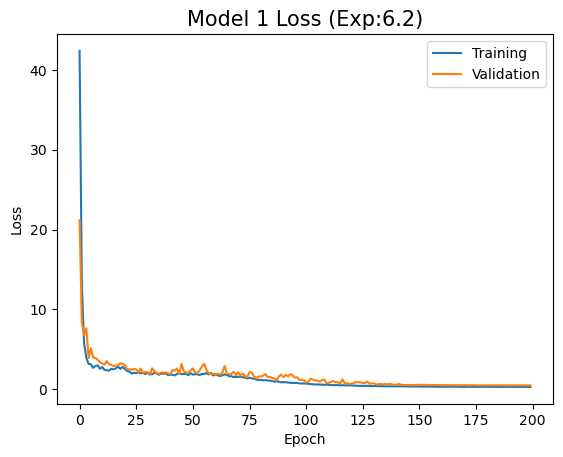

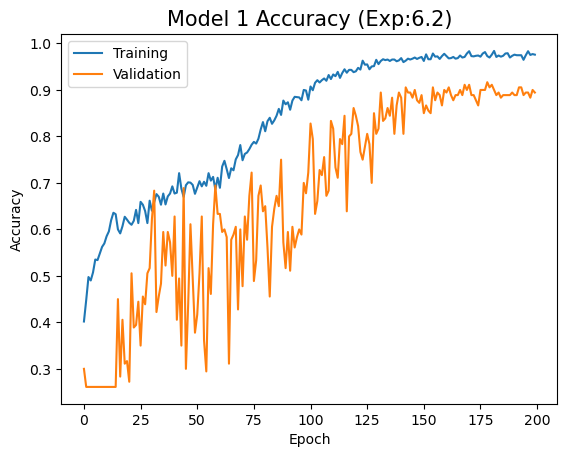

In [25]:
plot_history(history1, 'Model 1 Loss (Exp:6.2)', 'Model 1 Accuracy (Exp:6.2)')

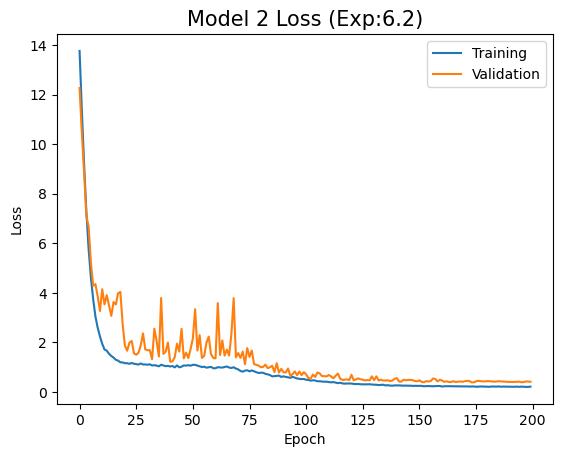

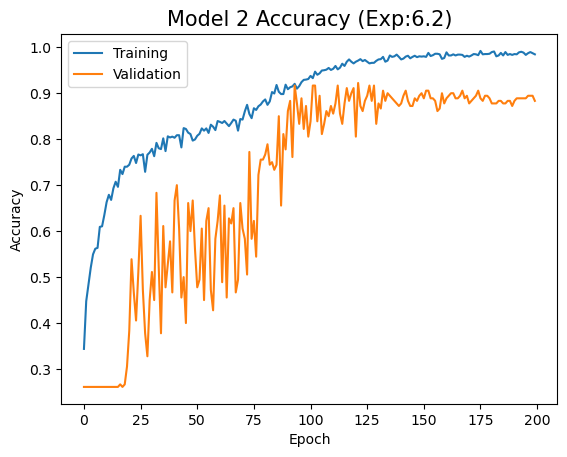

In [26]:
plot_history(history2, 'Model 2 Loss (Exp:6.2)', 'Model 2 Accuracy (Exp:6.2)')

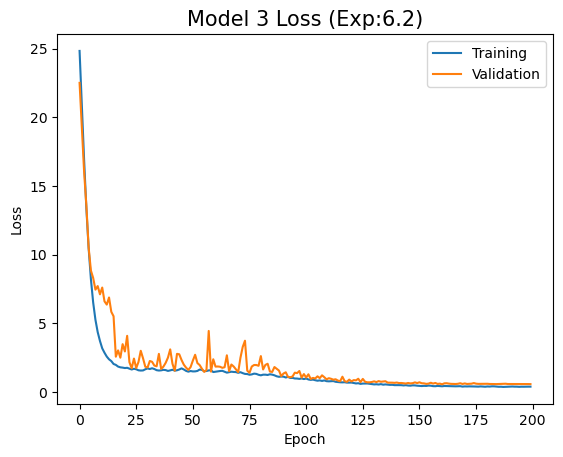

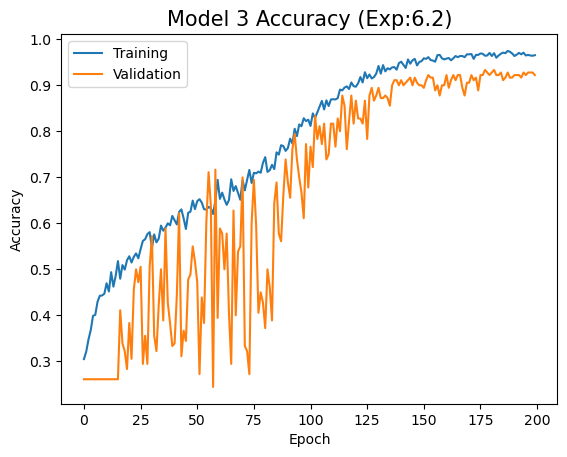

In [27]:
plot_history(history3, 'Model 3 Loss (Exp:6.2)', 'Model 3 Accuracy (Exp:6.2)')

## Evaluate the model for test images

In [28]:
# Evaluate the test result for model 1, 2, 3
model_1.load_weights(checkpoint_filepath1)
Test_result1 = model_1.evaluate(test_images, test_labels, batch_size = 64)

model_2.load_weights(checkpoint_filepath2)
Test_result2 = model_2.evaluate(test_images, test_labels, batch_size = 64)

model_3.load_weights(checkpoint_filepath3)
Test_result3 = model_3.evaluate(test_images, test_labels, batch_size = 64)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9247 - loss: 0.4431
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9014 - loss: 0.4575
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9309 - loss: 0.4796


## Confusion matrix for model 1 to 3

In [29]:
# Model 1 confusion matrix
predictions1 = model_1.predict(test_images)     # Vector of probabilities
pred_label1 = np.argmax(predictions1, axis = 1) # We take the highest probability

# Model 2 confusion matrix
predictions2 = model_2.predict(test_images)     # Vector of probabilities
pred_label2 = np.argmax(predictions2, axis = 1) # We take the highest probability

# Model 3 confusion matrix
predictions3 = model_3.predict(test_images)     # Vector of probabilities
pred_label3 = np.argmax(predictions3, axis = 1) # We take the highest probability

def C_Matrix(test_label, pred_label, CM_Title):
    """
    Display the confusion matrix
    
    Parameter
    arg1 : Test label
    arg2 : Predicted label
    arg3 : Confusion Matrix Title
        
    Return: Display the Confusion matrix for actual and predicted label  
    """
    CM = confusion_matrix(test_label, pred_label)
    ax = plt.axes()
    sns.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=waste_class_names, 
           yticklabels=waste_class_names, ax = ax)
    ax.set_title(CM_Title)
    plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


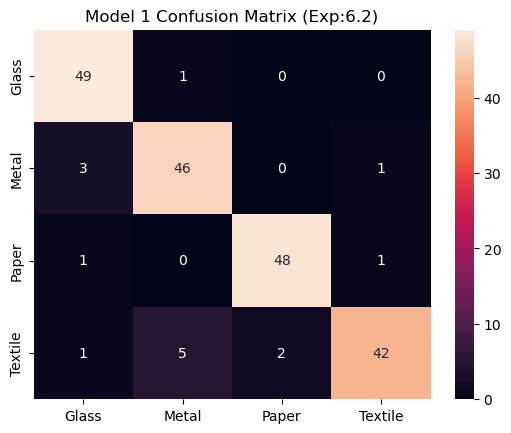

In [30]:
C_Matrix(test_labels, pred_label1, 'Model 1 Confusion Matrix (Exp:6.2)')

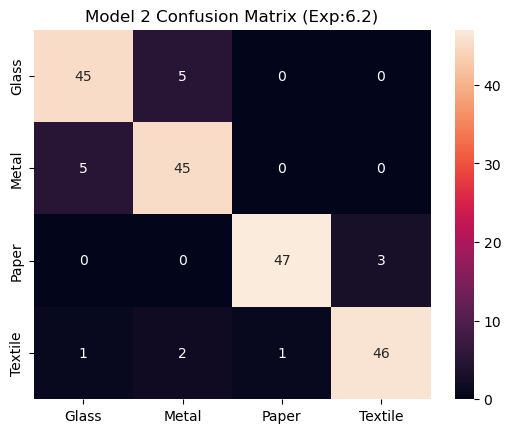

In [31]:
C_Matrix(test_labels, pred_label2, 'Model 2 Confusion Matrix (Exp:6.2)')

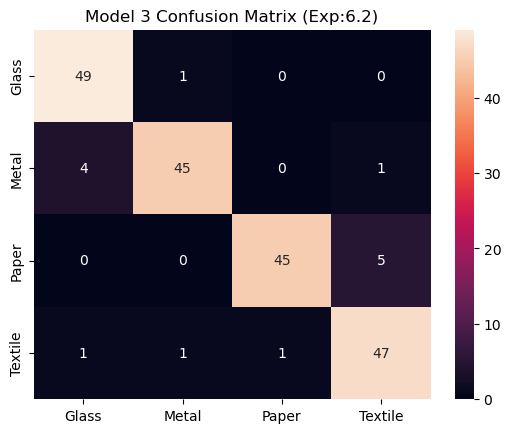

In [32]:
C_Matrix(test_labels, pred_label3, 'Model 3 Confusion Matrix (Exp:6.2)')

## Display 25 images for each model with actual and predicted label

25 random image with actual and predicted label for Model 1


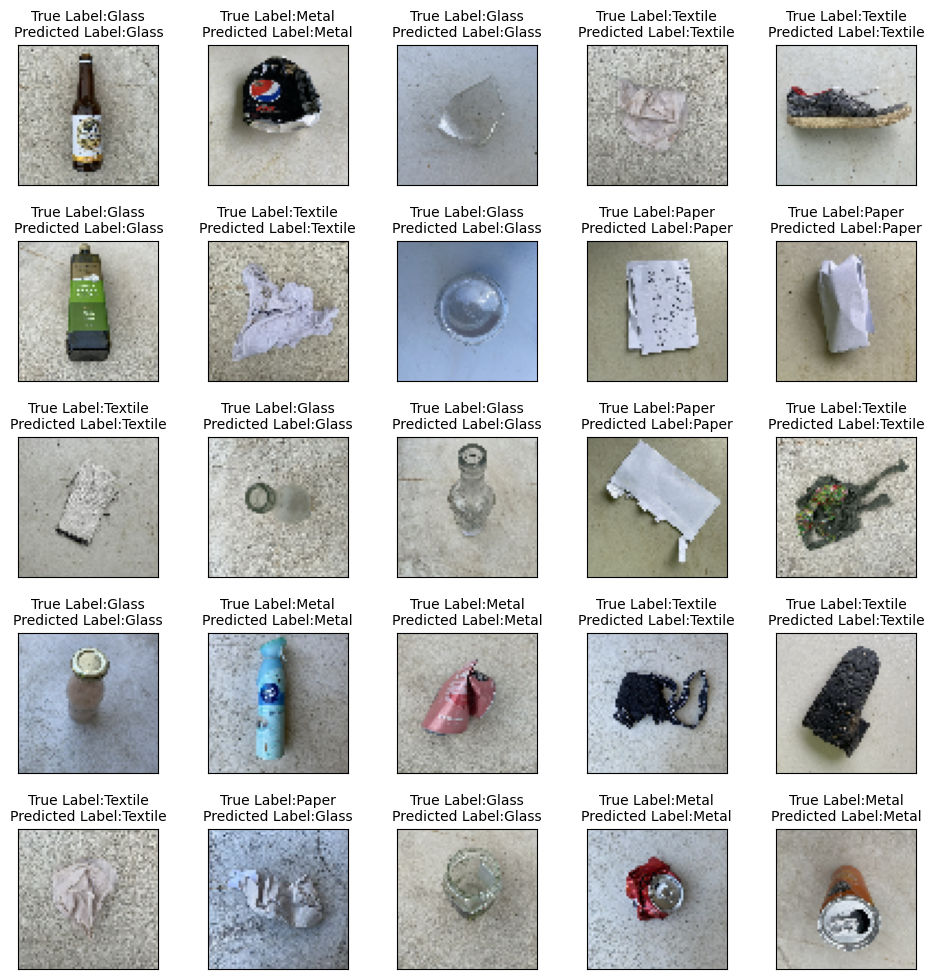

In [33]:
#Display actual and predicted labels for 25 images model 1
print('25 random image with actual and predicted label for Model 1')
fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace = 0.4, wspace = 0.1)

for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    #plt.grid(False)
    plt.imshow(test_images[i])
    plt.title("True Label:" + waste_class_names[test_labels[i]] +"\n"+"Predicted Label:"
              + waste_class_names[pred_label1[i]], fontsize = 10)
 

25 random image with actual and predicted label for Model 2


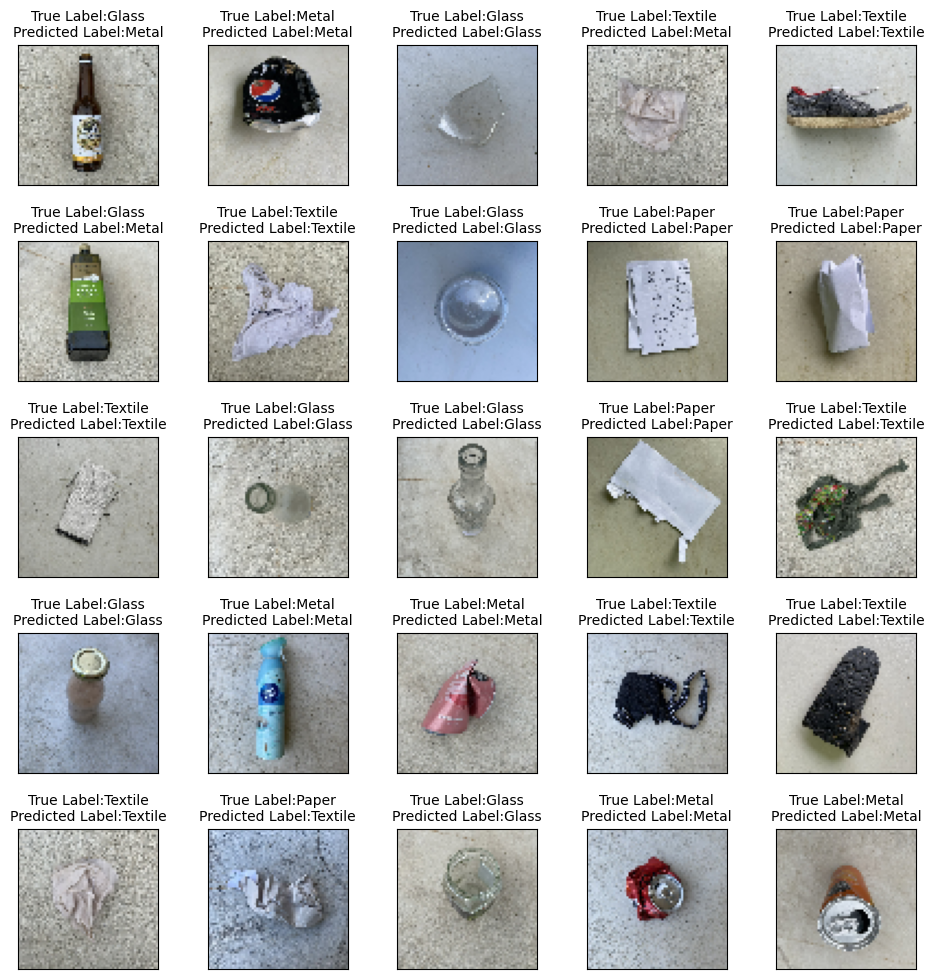

In [34]:
#Display actual and predicted labels for 25 images for model 2
print('25 random image with actual and predicted label for Model 2')
fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace = 0.4, wspace = 0.1)

for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    #plt.grid(False)
    plt.imshow(test_images[i])
    plt.title("True Label:" + waste_class_names[test_labels[i]] +"\n"+"Predicted Label:"
              + waste_class_names[pred_label2[i]], fontsize = 10)
    

25 random image with actual and predicted label for Model 3


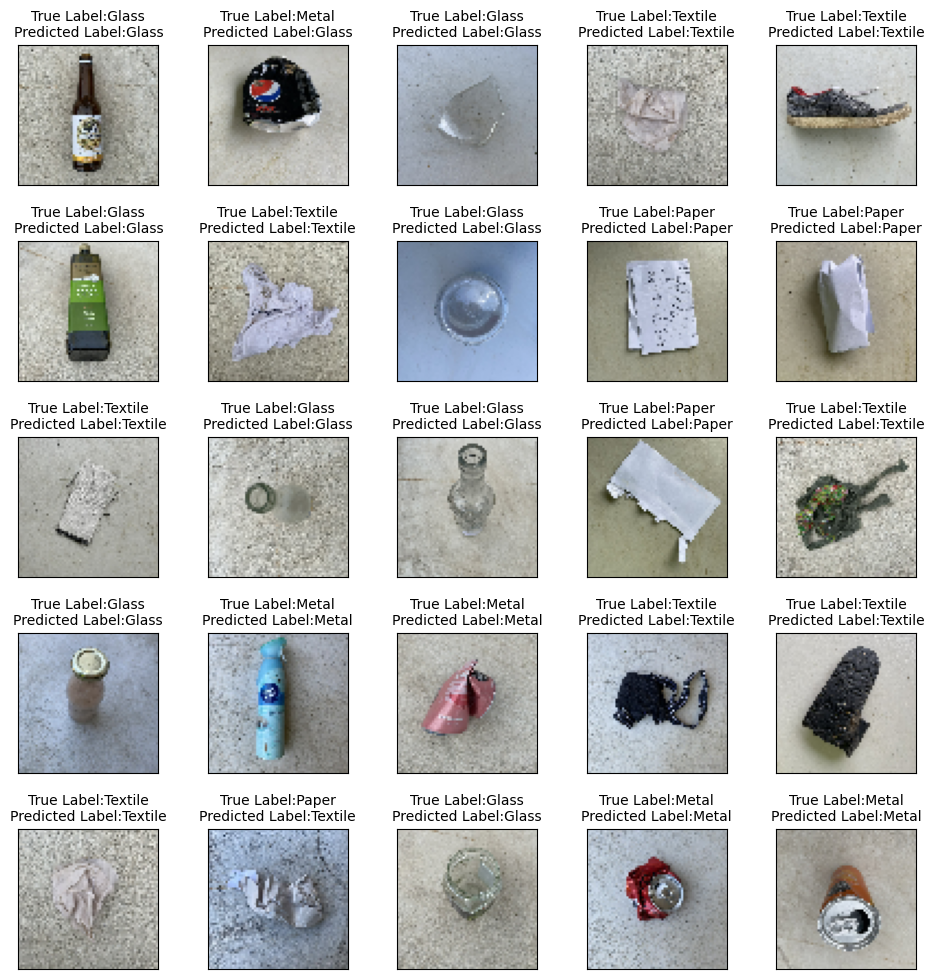

In [35]:
#Display actual and predicted labels for 25 images for model 3
print('25 random image with actual and predicted label for Model 3')
fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace = 0.4, wspace = 0.1)

for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    #plt.grid(False)
    plt.imshow(test_images[i])
    plt.title("True Label:" + waste_class_names[test_labels[i]] +"\n"+"Predicted Label:"
              + waste_class_names[pred_label3[i]], fontsize = 10)
    

## Display the misclassied image for model 1 to 3

In [36]:
def display_mislabel_images(class_names, waste_images, labels):
    """
    Display the misclassified images and labels
    
    Parameter
    arg1 : waste class names
    arg2 : images
    arg3 : labels
        
    Return: Display the number of misclassified images with labels   
    """
    fig = plt.figure(figsize=(15,15))
    #fig.suptitle("mislabeled images", fontsize=16)
    for i in range(7):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(waste_images[i], cmap=plt.cm.binary)
        plt.xlabel(waste_class_names[labels[i]], fontsize = 15) 
    plt.show()
    
def print_mislabeled_images(waste_class_names, test_images, test_labels, pred_labels):
    
    """
    Extract the misclassified images and labels
    
    Parameter
    arg1 : waste_class_names
    arg2 : test_images
    arg3 : test_labels
    arg4 : pred_labels
        
    Return: Display the number of misclassified images with label 
    """
    correct_label = (test_labels == pred_labels)
    mislabeled_indices = np.where(correct_label == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]
         
    display_mislabel_images(waste_class_names,  mislabeled_images, mislabeled_labels)   


Mislabel image for model 1


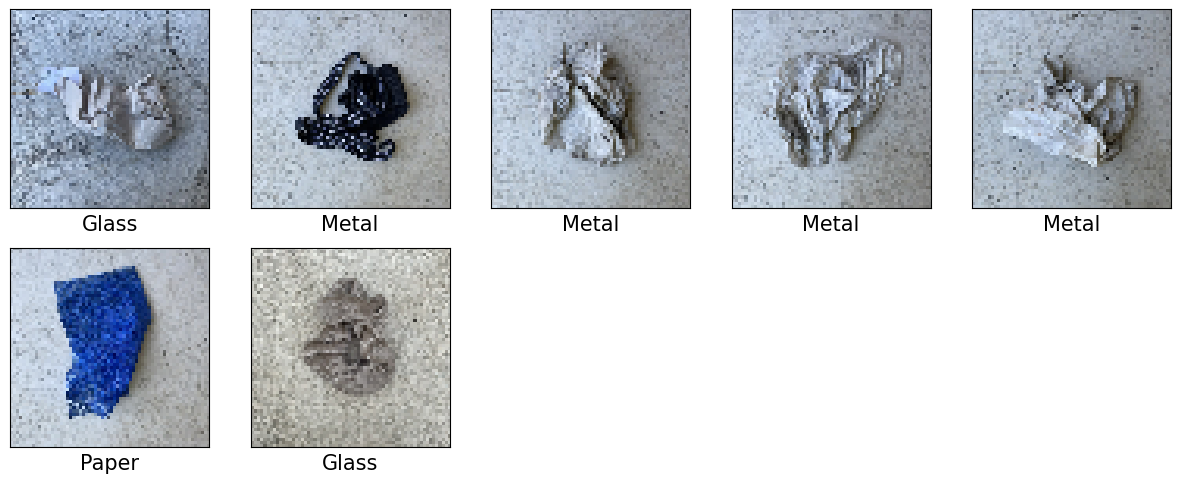

In [37]:
print('Mislabel image for model 1')
print_mislabeled_images(waste_class_names, test_images, test_labels, pred_label1)

Mislabel image for model 2


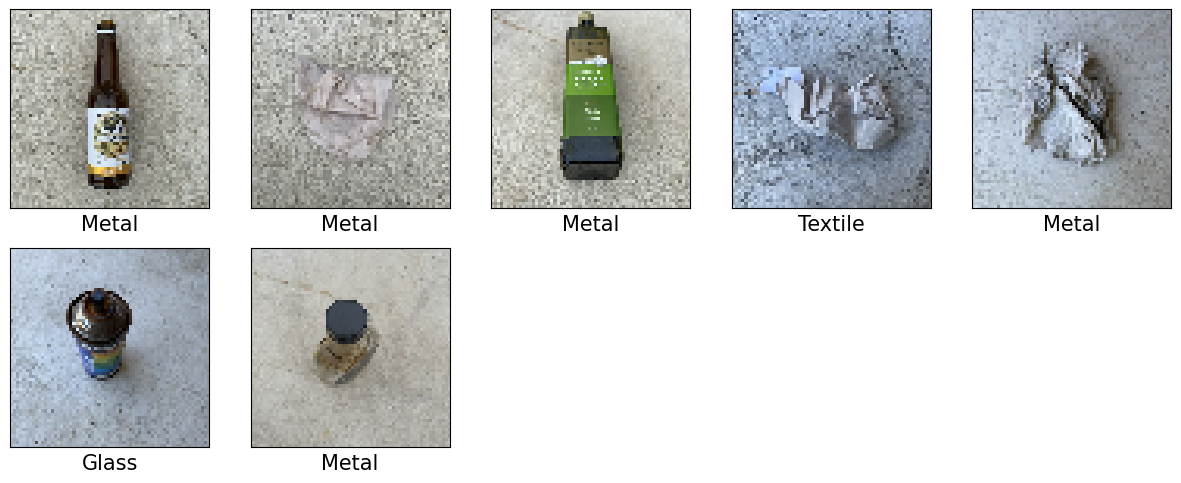

In [38]:
print('Mislabel image for model 2')
print_mislabeled_images(waste_class_names, test_images, test_labels, pred_label2)

Mislabel image for model 3


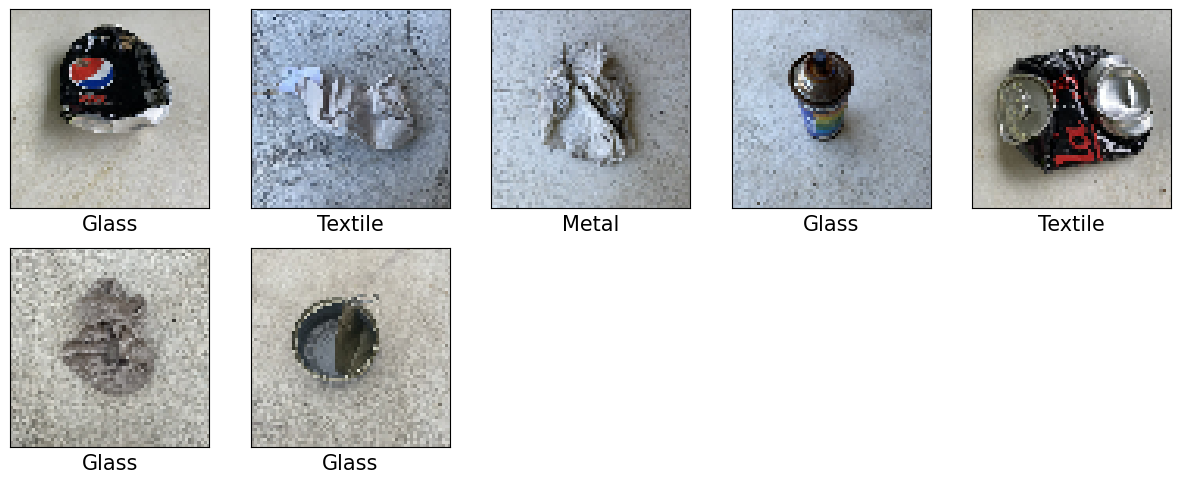

In [39]:
print('Mislabel image for model 3')
print_mislabeled_images(waste_class_names, test_images, test_labels, pred_label3)

## Predict a single image

In [121]:
IMAGE_SIZE = (64,64)
test_imageP = cv.imread("C:/test_ds/Glass/Glass_2.jpg")
                        
def predict(model):
    start_time = datetime.now()
    
    test_image1 = test_imageP
    test_image1 = cv.cvtColor(test_image1, cv.COLOR_BGR2RGB)
    test_image1 = cv.resize(test_image1, IMAGE_SIZE) 
    im1= tf.constant(test_image1, dtype = tf.float32)
    im1= tf.expand_dims(im1,axis = 0)
    im1 = im1 / 255.0
    plt.title('predicted label: ' + waste_class_names[np.argmax(model(im1))])
    plt.imshow(test_image1)
    plt.grid(False)
    plt.axis('off')
    plt.show()

    end_time = datetime.now()
    #print('Predict end:', end_time)
    print('Prediction time:', end_time - start_time)
    

Model 1 Prediction


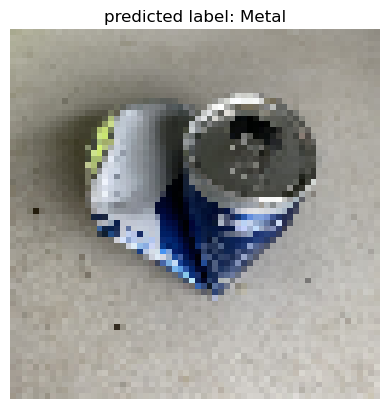

Prediction time: 0:00:00.107377


In [128]:
test_imageP = cv.imread("C:/test_ds/Metal/Metal_2.jpg")
print("Model 1 Prediction")
predict(model_1)

Model 2 Prediction


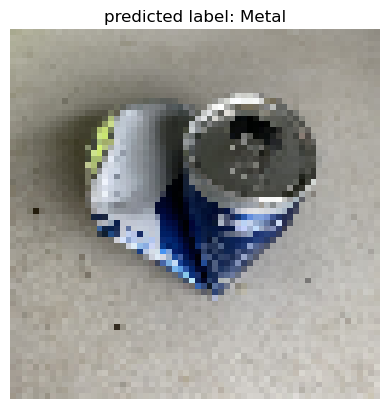

Prediction time: 0:00:00.108922


In [129]:
test_imageP = cv.imread("C:/test_ds/Metal/Metal_2.jpg")
print("Model 2 Prediction")
predict(model_2)

Model 3 prediction


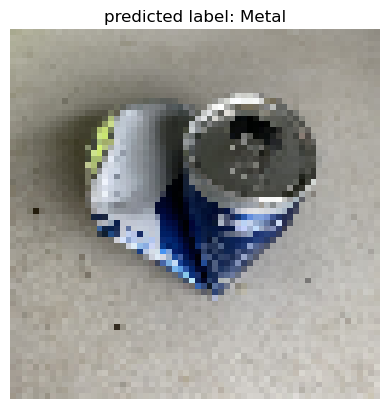

Prediction time: 0:00:00.120011


In [130]:
test_imageP = cv.imread("C:/test_ds/Metal/Metal_2.jpg")
print("Model 3 prediction")
predict(model_3)

## Pre-Training model - Transfer Learning

In [44]:
# Define the class label and image size
waste_class_names = ['Glass', 'Metal', 'Paper', 'Textile']
waste_class_label = {waste_class_name: i for i, waste_class_name in enumerate(waste_class_names)}
number_of_class = len(waste_class_names)
image_size = (224, 224)

In [45]:
#Prepare dataset for training and testing for Pre-train Model
(train_images1, train_labels1), (test_images1, test_labels1) = load_waste_data(train_ds_2, test_ds_2)

Loading waste image C:/Mani/Dataset/dataset2/train_ds


100%|███████████████████████████████████████████████████████████████████████████████| 450/450 [00:02<00:00, 207.34it/s]


Loading waste image C:/Mani/Dataset/dataset2/test_ds


100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 182.93it/s]


In [46]:
# Shuffle only the training dataset
np.random.seed(321)
train_images1, train_labels1 = shuffle(train_images1, train_labels1)
test_images1, test_labels1 = shuffle(test_images1, test_labels1)

In [47]:
#Check the training and testing image shape - should 224 by 224 for Resnet50
train_images1.shape, test_images1.shape

((1800, 224, 224, 3), (200, 224, 224, 3))

In [48]:
# Add callbacks to save the model weight with best accuracy during training
# import ModelCheckpoint package
# from tensorflow.keras.callbacks import ModelCheckpoint
# Source: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

checkpoint_filepath4 = 'C:/Mani/ModelCheckpoint/model4.keras'
model_checkpoint_callback4 = ModelCheckpoint(
    filepath=checkpoint_filepath4,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)


checkpoint_filepath5 = 'C:/Mani/ModelCheckpoint/model5.keras'
model_checkpoint_callback5 = ModelCheckpoint(
    filepath=checkpoint_filepath5,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)


## Pre-Trained Model - EfficientNetV2L

In [49]:
#EfficientNet pre-trained model
base_model = tf.keras.applications.EfficientNetV2L(
    include_top=False,
    weights='imagenet',
    input_shape=((224,224,3)),
    )

base_model.trainable = False

# Build EfficientNetV2 model for waste classification

model_EfficientNetV2 = tf.keras.Sequential([
    tf.keras.layers.Input((224,224,3)),
    base_model,
    tf.keras.layers.Conv2D(32, (3,3),padding='same', kernel_regularizer=regularizers.l2(0.05), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(1024, kernel_regularizer=regularizers.l2(0.6), activation='relu'),
    tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(0.6), activation='relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')      
])

model_EfficientNetV2.summary()    



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-l (Functional)        │ (None, 7, 7, 1280)          │     117,746,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 7, 7, 32)            │         368,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 3, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 3, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,153,028 (450.72 MB)

 Trainable params: 406,180 (1.55 MB)

 Non-trainable params: 117,746,848 (449.17 MB)

In [50]:
#Compile Efficientnet model

base_learning_rate = 0.0003
model_EfficientNetV2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])


## Fit EfficientNet 

In [51]:
E_epochs = 40
# Get the current time
start_time = datetime.now()

history4 = model_EfficientNetV2.fit(train_images1, train_labels1,
                       batch_size=batch_size, epochs= E_epochs, 
                       validation_split = 0.1, verbose=1,
                       callbacks=[model_checkpoint_callback4
                                 ])

# Get the current time
end_time = datetime.now()
print('EfficientNetV2_training_time', end_time - start_time )

Epoch 1/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.5211 - loss: 106.0974 
Epoch 1: val_accuracy improved from -inf to 0.88889, saving model to C:/Mani/ModelCheckpoint/model4.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 424s 14s/step - accuracy: 0.5263 - loss: 105.9181 - val_accuracy: 0.8889 - val_loss: 90.6468
Epoch 2/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.8528 - loss: 86.5455 
Epoch 2: val_accuracy improved from 0.88889 to 0.92778, saving model to C:/Mani/ModelCheckpoint/model4.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 381s 15s/step - accuracy: 0.8533 - loss: 86.4032 - val_accuracy: 0.9278 - val_loss: 74.0012
Epoch 3/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9049 - loss: 70.6007 
Epoch 3: val_accuracy did not improve from 0.92778
26/26 ━━━━━━━━━━━━━━━━━━━━ 338s 13s/step - accuracy: 0.9054 - loss: 70.4817 - val_accuracy: 0.9222 - val_loss: 60.2040
Epoch 4/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9178 - loss: 57.3628 
Epoch 4: val_accuracy improved 

## Accuracy plot and loss plot for EfficientNet

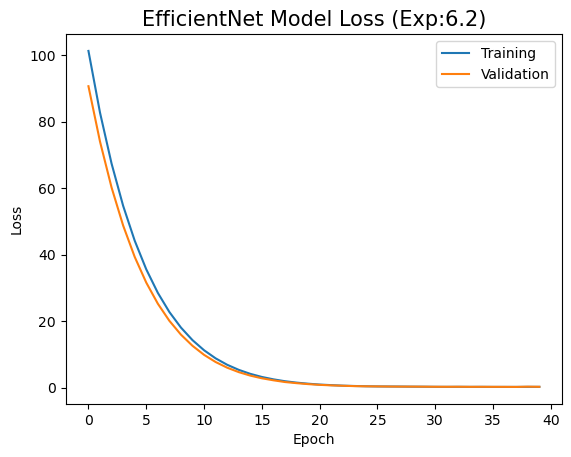

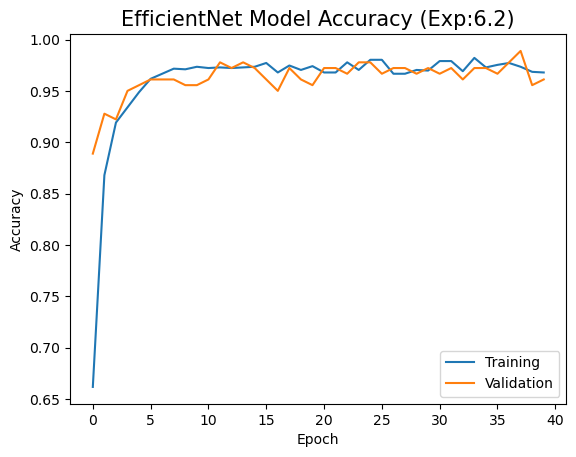

In [52]:
plot_history(history4, 'EfficientNet Model Loss (Exp:6.2)', 'EfficientNet Model Accuracy (Exp:6.2)')

In [53]:
#Load the best model1 weight from checkpoint
# Evaluate the test result EfficientNet

model_EfficientNetV2.load_weights(checkpoint_filepath4)
Test_result4 = model_EfficientNetV2.evaluate(test_images1, test_labels1, batch_size = 64)

4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 8s/step - accuracy: 0.9537 - loss: 0.3110


In [54]:
# Reference tf.keras.applications.EffificentNetV2L - tensorflow > API > Tensorflow v2.16.1 > Python
#Obtain the model's prediction for the test_images
prediction4 = model_EfficientNetV2.predict(test_images1)
pred_label4 = np.argmax(prediction4, axis = 1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 59s 7s/step


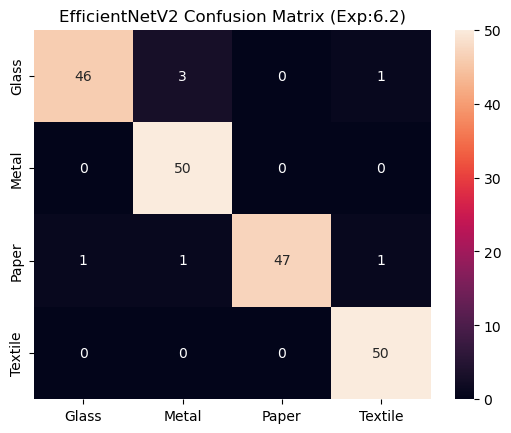

In [55]:
C_Matrix(test_labels, pred_label4, 'EfficientNetV2 Confusion Matrix (Exp:6.2)')

## Pre-Train model - MobileNetV3Large

In [56]:
#base_model_MobileNetV3Large

base_model_MobileNetV3 = tf.keras.applications.MobileNetV3Large(
    include_top=False,
    weights='imagenet',
    input_shape=((224,224,3)),
    )

base_model_MobileNetV3.trainable = False

# Build MobileNetV3 model for waste classification

model_MobileNetV3 = tf.keras.Sequential([
    tf.keras.layers.Input((224,224,3)),
    base_model_MobileNetV3,
    tf.keras.layers.Conv2D(128, (3,3),padding='same', kernel_regularizer=regularizers.l2(0.05), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    #tf.keras.layer.GlobalMaxPool2D((2,2))
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(1024, kernel_regularizer=regularizers.l2(0.6), activation='relu'),
    tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(0.06), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')      
])

model_MobileNetV3.summary()  

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ MobilenetV3large (Functional)        │ (None, 7, 7, 960)           │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 7, 7, 128)           │       1,106,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,251,012 (16.22 MB)

 Trainable params: 1,254,404 (4.79 MB)

 Non-trainable params: 2,996,608 (11.43 MB)

In [57]:
#Compile and fit MobileNet model

Mobile_learning_rate = 0.0002
M_epochs = 40

model_MobileNetV3.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = Mobile_learning_rate),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])

# Get the current time
start_time = datetime.now()

history5 = model_MobileNetV3.fit(train_images1, train_labels1,
                       batch_size=batch_size, epochs= M_epochs, 
                       validation_split = 0.1, verbose=1,
                       callbacks=[model_checkpoint_callback5])

# Get the current time
end_time = datetime.now()
print('MobileNetV3_training_time', end_time - start_time )

Epoch 1/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 938ms/step - accuracy: 0.4587 - loss: 26.2276
Epoch 1: val_accuracy improved from -inf to 0.85000, saving model to C:/Mani/ModelCheckpoint/model5.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.4634 - loss: 26.1947 - val_accuracy: 0.8500 - val_loss: 23.7665
Epoch 2/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 990ms/step - accuracy: 0.8299 - loss: 23.0357
Epoch 2: val_accuracy improved from 0.85000 to 0.89444, saving model to C:/Mani/ModelCheckpoint/model5.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8307 - loss: 23.0138 - val_accuracy: 0.8944 - val_loss: 21.0567
Epoch 3/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 938ms/step - accuracy: 0.9039 - loss: 20.5138
Epoch 3: val_accuracy improved from 0.89444 to 0.92778, saving model to C:/Mani/ModelCheckpoint/model5.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9044 - loss: 20.4931 - val_accuracy: 0.9278 - val_loss: 18.6598
Epoch 4/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 918ms/step - accuracy: 

## Accuracy plot and loss plot for MobileNetV3

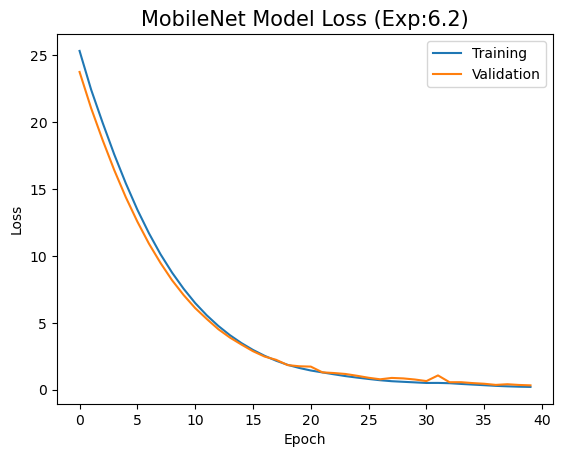

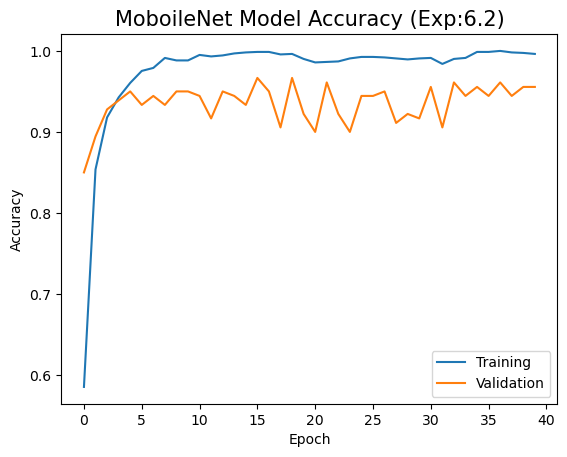

In [58]:
plot_history(history5, 'MobileNet Model Loss (Exp:6.2)', 'MoboileNet Model Accuracy (Exp:6.2)')

In [59]:
#Load the best mobileNetV3 weight from checkpoint_filepath5
model_MobileNetV3.load_weights(checkpoint_filepath5)
MobileNetV3_result = model_MobileNetV3.evaluate(test_images1, test_labels1)

print('MobileNetV3 accuracy:', MobileNetV3_result)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 473ms/step - accuracy: 0.9488 - loss: 2.8852
MobileNetV3 accuracy: [2.8585803508758545, 0.9549999833106995]


In [60]:
# Reference tf.keras.applications.EffificentNetV2L - tensorflow > API > Tensorflow v2.16.1 > Python
#Obtain the model's prediction for the test_images
prediction5 = model_MobileNetV3.predict(test_images1)
pred_label5 = np.argmax(prediction5, axis = 1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 671ms/step


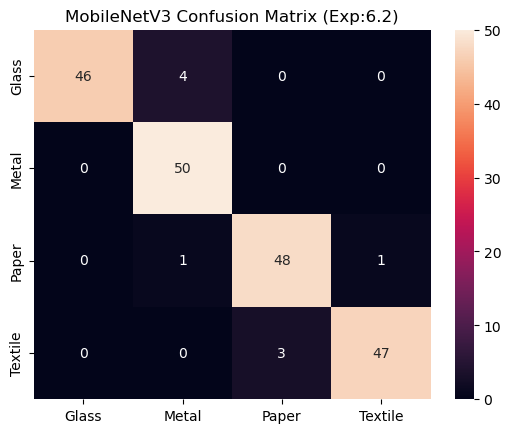

In [61]:
C_Matrix(test_labels, pred_label5, 'MobileNetV3 Confusion Matrix (Exp:6.2)')

## Display Misclassified Images

In [83]:
def display_mislabel_images(waste_class_names, images, labels):
    """
    Display the misclassified images and labels
    
    Parameter
    arg1 : waste class names
    arg2 : images
    arg3 : labels
        
    Return: Display the number of misclassified images with labels   
    """
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("mislabeled images", fontsize=16)
    for i in range(9):
        plt.subplot(4,3,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i] /255.0, cmap=plt.cm.binary)
        plt.xlabel(waste_class_names[labels[i]], fontsize = 15)
        
plt.show()

def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
    Extract the misclassified images and labels
    
    Parameter
    arg1 : waste_class_names
    arg2 : test_images
    arg3 : test_labels
    arg4 : pred_labels
        
    Return: Display the number of misclassified images with label 
    """
    correct_label = (test_labels == pred_labels)
    mislabeled_indices = np.where(correct_label == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]
    actual_label = test_labels[mislabeled_indices]

      
    display_mislabel_images(waste_class_names,  mislabeled_images, mislabeled_labels)


EfficientNetV2


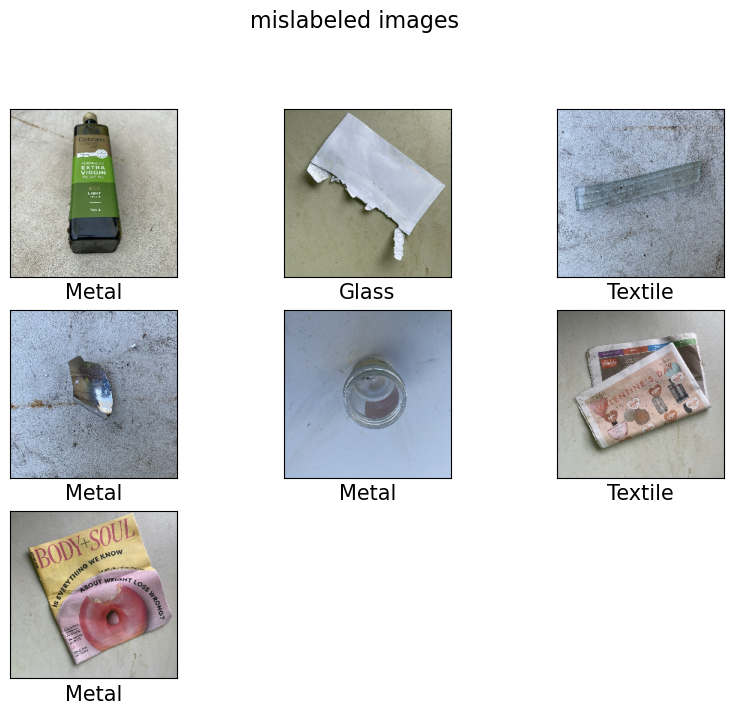

In [82]:
print('EfficientNetV2')
print_mislabeled_images(waste_class_names, test_images1, test_labels1, pred_label4)

MobileNetV3


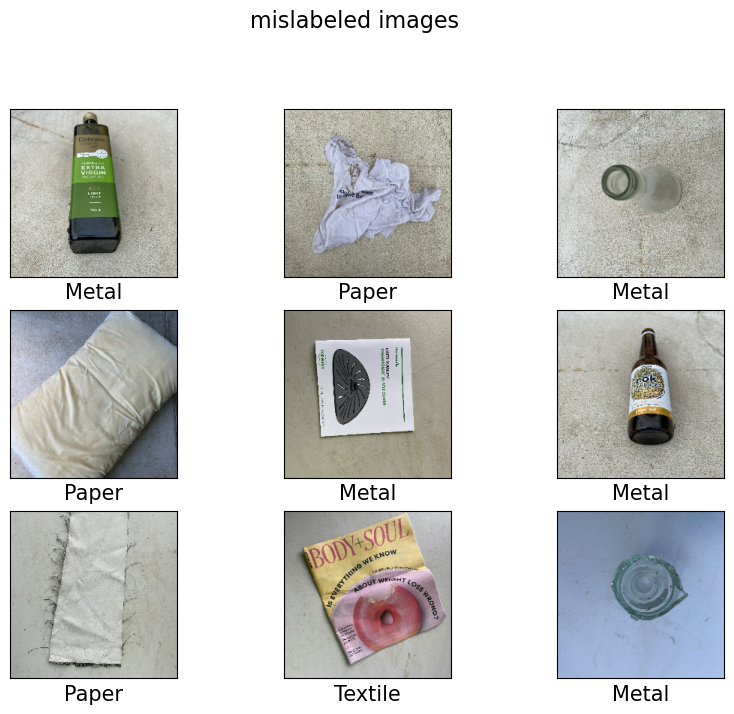

In [84]:
print('MobileNetV3')
print_mislabeled_images(waste_class_names, test_images1, test_labels1, pred_label5)

## Predict Single images for MobileNet and EfficientNet

In [ ]:
IMAGE_SIZE = (244,244)
test_imageP = cv.imread("C:/test_ds/Organics/Food Organics_2.jpg")
                        
def predict1(model):
    start_time = datetime.now()
    
    test_image1 = test_imageP
    #test_image1 = test_image1 / 255.0
    test_image1 = cv.cvtColor(test_image1, cv.COLOR_BGR2RGB)
    test_image1 = cv.resize(test_image1, IMAGE_SIZE) 
    im1= tf.constant(test_image1, dtype = tf.float32)
    im1= tf.expand_dims(im1,axis = 0)
    #im1 = im1 / 255.0
    plt.title('predicted label: ' + waste_class_names[np.argmax(model(im1))])
    plt.imshow(test_image1)
    plt.grid(False)
    plt.axis('off')
    plt.show()

    end_time = datetime.now()
    #print('Predict end:', end_time)
    print('Prediction time:', end_time - start_time)

MobileNetV3 prediction


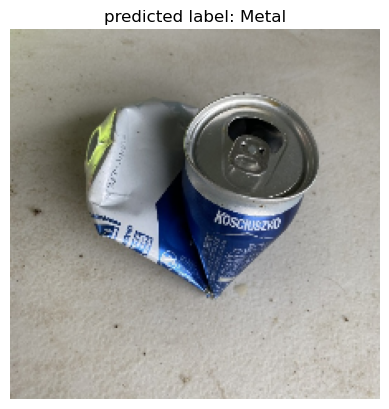

Prediction time: 0:00:00.484756


In [79]:
test_imageP = cv.imread("C:/test_ds/Metal/Metal_2.jpg")
print("MobileNetV3 prediction")
predict1(model_MobileNetV3)

EfficientNetV2 prediction


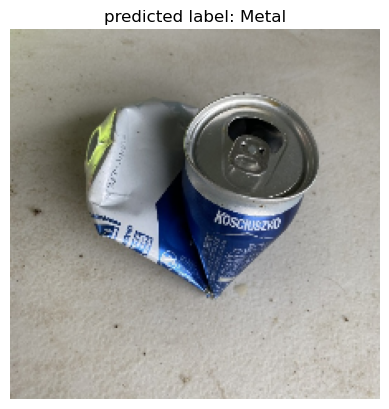

Prediction time: 0:00:01.962506


In [80]:
print("EfficientNetV2 prediction")
predict1(model_EfficientNetV2)